In [156]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from datetime import datetime
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import plotly.express as px
# https://www.python-graph-gallery.com/

In [3]:
# https://plotly.com/python/choropleth-maps/



df = px.data.gapminder().query("year==2007")
fig = px.choropleth(df, locations="iso_alpha",
                    color="lifeExp", # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

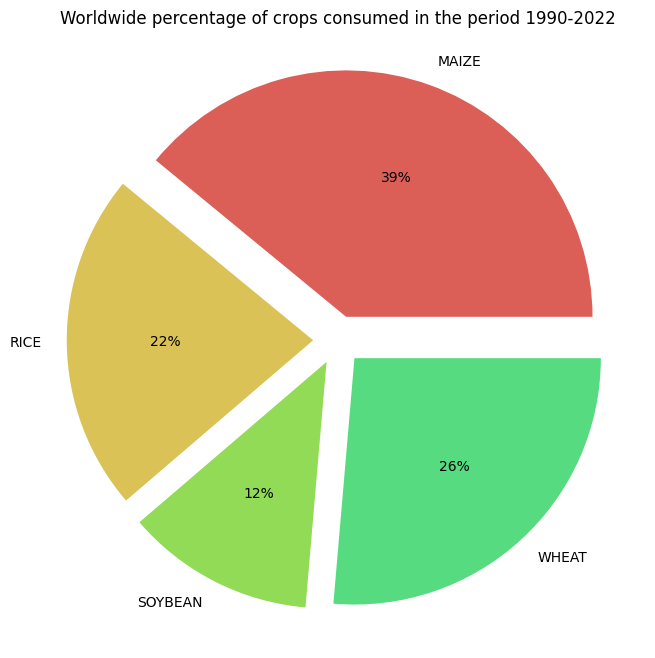

In [122]:
wcrop = pd.read_csv('datasets/worldwide_crop_consumption.csv')
wcrop.head()
# 0,1,,2,3...  LOCATION, SUBJECT, MEASURE, TIME, Value
wcrop['SUBJECT'].unique()
wcrop['LOCATION'].unique()

#wcrop['timeint'] = wcrop["TIME"].astype('int32')
wcropNow = wcrop.query("TIME < 2023")

#each crop ha a different measure unit, just choose one
#TONNE_HA, THND_TONNE, THND_HA
# df2=df.loc[(df['Discount'] >= 1200) | (df['Fee'] >= 23000 )]
wcropNow.drop(wcropNow.loc[(wcropNow['MEASURE'] == 'THND_HA') | (wcropNow['MEASURE'] == 'TONNE_HA')].index, axis=0, inplace=True)

minyear = wcropNow['TIME'].min()
maxyear = wcropNow['TIME'].max()


# MAP OF QUANTITY OF CROP CONSUMED ALL TIME, FROM 1990 TO 2022

consalltime = wcropNow.groupby('LOCATION').sum()
wldalltime = consalltime.loc["WLD", "Value"]

consalltime.drop("WLD", axis=0, inplace=True)
consalltime.drop("BRICS", axis=0, inplace=True)
consalltime.drop("OECD", axis=0, inplace=True)
consalltime.drop("EU28", axis=0, inplace=True)

vmin = consalltime.Value.min()
vmax = consalltime.Value.max()

fig = px.choropleth(consalltime, locations=consalltime.index,
                    color="Value", # lifeExp is a column of gapminder
                    hover_name=consalltime.index, # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
                    #color_continuous_scale=[(0, "red"), (0.5, "green"), (1, "blue")]
                    #color_continuous_scale=px.colors.diverging.BrBG
                    #color_continuous_scale='Bluered_r'
fig.show()

# PERCENTAGE OF CONSUMED CROPS WORLDWIDE

wcropNow['SUBJECT'].unique() # ['RICE', 'WHEAT', 'SOYBEAN', 'MAIZE']

cropPerc = wcropNow.drop(wcropNow.loc[(wcropNow['LOCATION'] == 'WLD')].index, axis=0, inplace=False).drop(wcropNow.loc[(wcropNow['LOCATION'] == 'EU28')].index, axis=0, inplace=False).drop(wcropNow.loc[(wcropNow['LOCATION'] == 'BRICS')].index, axis=0, inplace=False).drop(wcropNow.loc[(wcropNow['LOCATION'] == 'OECD')].index, axis=0, inplace=False)

cropPerc = cropPerc.groupby(by='SUBJECT').sum()
cropPerc['perc'] = cropPerc['Value'] / cropPerc['Value'].sum()
cropPerc.reset_index(inplace=True)

plt.figure(figsize=(12, 8))

plt.pie(cropPerc['perc'], labels = cropPerc['SUBJECT'], colors= sns.color_palette("hls", 8), autopct='%.0f%%', explode=(0.1,0.1,0.1,0.1))

plt.title("Worldwide percentage of crops consumed in the period 1990-2022")

plt.show()

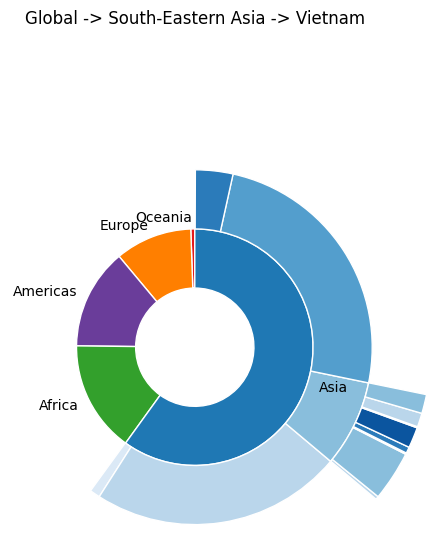

In [253]:
wd = pd.read_csv("datasets/world_data.csv", sep=";")
#print(wd.head())
# region, subregion, key, value

# remove nans
wd.drop(wd[wd["value"] == -1].index, axis=0, inplace=True)

regSum = wd.groupby(by="region").sum()
regSum.reset_index(inplace=True)
regSum['perc'] = regSum['value'] / regSum.value.sum()
regSum.sort_values(by="perc", inplace=True)
regSum.reset_index(inplace=True)


#print(wd['subregion'].unique())
# Southern Asia, South-Eastern Asia
wd[wd["subregion"] == "South-Eastern Asia"] # (9,4)
# Western Asia, 
#subrSum1 = wd.query("subregion == 'Southern Asia' | subregion == 'Southern Asia' | subregion == 'Eastern Asia'")
#column_name.str.contains("abc")
subr1 = wd.query("subregion.str.contains('Asia')", engine="python")
subr1.subregion.unique() # ['Southern Asia', 'Western Asia', 'South-Eastern Asia', 'Eastern Asia', 'Central Asia']

subr1 = subr1.groupby(by="subregion").sum()
#subr1['perc'] = subr1.value / subr1.value.sum()
subr1['perc'] = subr1.value / regSum.value.sum()


subr1.reset_index(inplace=True)

key = wd.query("subregion == 'South-Eastern Asia'")
#key['perc'] = key.value / key.value.sum()
key['perc'] = key.value / regSum.value.sum()
key.reset_index(inplace=True)

keylabels = [ f"{str(a)} {str(b*100)[:4]}" for (a,b) in zip(key.key, key.perc)]

#now plot concetric donuts
fig, ax = plt.subplots()

rad= 1.6
size = 0.4
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

cmap = plt.colormaps["tab20c"]
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 2, 5, 6, 9, 10])

textprops = {"fontsize":8,'color':'black'}

ax.pie(regSum.perc, radius=rad-2*size, colors=['#e31a1c', '#ff7f00', "#6a3d9a",'#33a02c', '#1f78b4' ], labels=regSum.region,
       startangle=90, frame = True,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(subr1.perc, radius=rad-size, colors=sns.color_palette("Blues"),
       wedgeprops=dict(width=size, edgecolor='w'),
      normalize=False, startangle=234
      )

ax.pie(key.perc, radius=rad, 
       wedgeprops=dict(width=size, edgecolor='w'),
       textprops=textprops,
       startangle=-40,
      normalize=False,
      colors=sns.color_palette("Blues"))

ax.set(aspect="equal")
plt.title("Global -> South-Eastern Asia -> Vietnam", loc="center", pad=100)
plt.show()

